
Tasks 24/11/2024

[ ] Convert feature engineering into a pipeline
[ ] Perform Cross-Validation prediction using pipeline

In [4]:
#Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Inspection and Ingestion

In this section we perform an initial inspection of the data to get a sense of columns, null values, potential erroneous values and detect any duplication while also constructing a data dictionary to summarise the meaning of variables.

In [5]:
#import the datasets from csv
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

datasets = [df_train, df_test]

for df in datasets:
    df.set_index("id", inplace=True)

In [6]:
#inspect the first five rows
df_train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


*Comments*

Looks like "working professional or student" indicates whether someone is a worker or student. Name, Profession, Degree and City looks like they will be high cardinality categories of questionable value and may need handling with target encoding. It is immediately clear that some columns only apply to students or workers with null values when they do not apply (for example Academic Pressure for a worker), perhaps these can be combined into single columns e.g. Job/Study Satisfaction. Sleep Duration and Dietary Habits appear to be ordinal categorical columns with low cardinality.

*Initial Hypotheses*

1. Suicidal thoughts will correlate highly with depression.
2. Financial stress will correlate highly with depression.
3. Financial stress will depend on whether someone is employed.
4. Students will be more susceptible to depression.
5. Young people will be more susceptible to depression than old people.
6. Age will correlate with student.
7. Lack of sleep will correlate heavily with depression.

In [7]:
#reformat column headers for simplicity
df_train.rename(columns={column: column.lower().replace(" ","_") for column in  df_train.columns},inplace=True)
df_test.rename(columns={column: column.lower().replace(" ","_") for column in  df_test.columns},inplace=True)

#further reformatting
df_train.rename(columns={"depression":"depressed", "have_you_ever_had_suicidal_thoughts_?":"suicidal_thoughts","family_history_of_mental_illness":"family_history","working_professional_or_student":"worker_or_student"}, inplace=True)
df_test.rename(columns={"depression":"depressed", "have_you_ever_had_suicidal_thoughts_?":"suicidal_thoughts","family_history_of_mental_illness":"family_history","working_professional_or_student":"worker_or_student"}, inplace=True)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name                140700 non-null  object 
 1   gender              140700 non-null  object 
 2   age                 140700 non-null  float64
 3   city                140700 non-null  object 
 4   worker_or_student   140700 non-null  object 
 5   profession          104070 non-null  object 
 6   academic_pressure   27897 non-null   float64
 7   work_pressure       112782 non-null  float64
 8   cgpa                27898 non-null   float64
 9   study_satisfaction  27897 non-null   float64
 10  job_satisfaction    112790 non-null  float64
 11  sleep_duration      140700 non-null  object 
 12  dietary_habits      140696 non-null  object 
 13  degree              140698 non-null  object 
 14  suicidal_thoughts   140700 non-null  object 
 15  work/study_hours    140700 non-nul

*Comments*

We have 18 feature columns and 1 target column "Depression" over 140,000 observations. We have null values in "Profession" (likely only applies to workers), "Academic Pressure" (likely only applies to students), "Work Pressure" (likely only applies to workers), "CGPA" and "Study Satisfaction" (likely only applies to students), "Job Satisfaction" again likely only applies to workers, we can see also some small count of null values in financial stress and degree, dietary habits, these can likely be imputed or even dropped as so small. If age is rounded to year can just be an integer.


markdown
Copy code
# Data Dictionary with Variable Types and Cardinality

| Column Name                               | Data Type   | Variable Type    | Description                                                                 | Cardinality                      |
|-------------------------------------------|-------------|------------------|-----------------------------------------------------------------------------|----------------------------------|
| `name`                                    | object      | Nominal          | Name of the individual (categorical).                                       | High (likely unique for each individual) |
| `gender`                                  | object      | Nominal          | Gender of the individual (e.g., male, female, other).                       | 3                                |
| `age`                                     | float64     | Continuous       | Age of the individual (numeric).                                            | Moderate                        |
| `city`                                    | object      | Nominal          | City of residence (categorical).                                            | High                             |
| `working_professional_or_student`         | object      | Nominal          | Employment status: working professional or student (categorical).           | 2                                |
| `profession`                              | object      | Nominal          | Profession of the individual (categorical, with missing values).            | Moderate to High (depending on dataset) |
| `academic_pressure`                       | float64     | Continuous       | Level of academic pressure experienced (numeric, many missing values).      | Low to Moderate                  |
| `work_pressure`                           | float64     | Continuous       | Level of work pressure experienced (numeric, some missing values).          | Moderate                        |
| `cgpa`                                    | float64     | Continuous       | Academic performance measured in CGPA (numeric, many missing values).       | Low to Moderate                  |
| `study_satisfaction`                      | float64     | Continuous       | Satisfaction level with academic studies (numeric, many missing values).    | Low                              |
| `job_satisfaction`                        | float64     | Continuous       | Satisfaction level with current job (numeric, some missing values).         | Low                              |
| `sleep_duration`                          | object      | Ordinal          | Sleep duration, typically in hours (categorical).                           | Low                              |
| `dietary_habits`                          | object      | Nominal          | Dietary habits (e.g., vegetarian, non-vegetarian, vegan) (categorical).     | Low                              |
| `degree`                                  | object      | Nominal          | Highest degree attained (categorical).                                      | Moderate                        |
| `have_you_ever_had_suicidal_thoughts_?`   | object      | Binary           | History of suicidal thoughts (Yes/No).                                      | 2                                |
| `work/study_hours`                        | float64     | Continuous       | Average work or study hours per day (numeric).                              | Moderate                        |
| `financial_stress`                        | float64     | Continuous       | Level of financial stress experienced (numeric, some missing values).       | Moderate                        |
| `family_history_of_mental_illness`        | object      | Binary           | Family history of mental illness (Yes/No).                                  | 2                                |
| `depression`                              | int64       | Binary           | Target variable: presence of depression (1 = Yes, 0 = No).                  | 2                                |

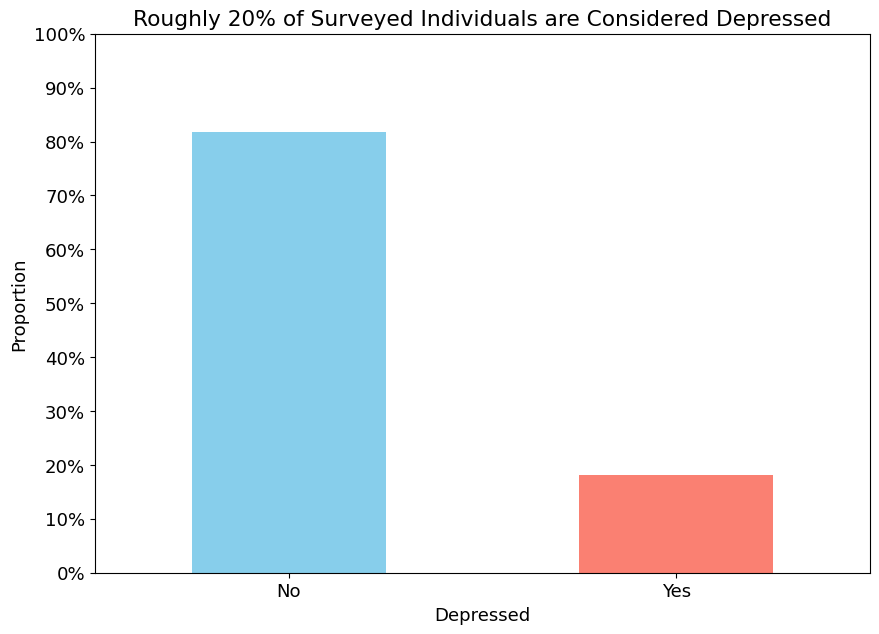

In [9]:
plt.rcParams['font.size'] = 13
plt.figure(figsize=(10,7))
plt.title("Roughly 20% of Surveyed Individuals are Considered Depressed")
plt.xlabel("Depressed")
plt.ylabel("Proportion")
df_train["depressed"].value_counts(normalize=True).plot(kind="bar", color=['skyblue', 'salmon'])
plt.xticks(ticks=[0,1], labels=["No","Yes"], rotation=0)
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=[f"{int(x*100)}%" for x in np.arange(0,1.1,0.1)])
plt.show()

We are dealing with a moderately imbalanced dataset, where only 20% of cases belong to the positive class. This imbalance may lead the model to favor the majority class. To address this, we can employ techniques like oversampling, undersampling, or a combination of both. Additionally, we can focus on algorithms that handle imbalance well, such as decision trees, while avoiding those more sensitive to imbalance, like logistic regression. Ensemble methods, such as random forests, are particularly effective in this context.

Another approach is to adjust class weights during training to balance the model’s focus on both classes. It’s important to prioritize metrics like the F1-score for the minority class to better capture performance. Finally, tuning the classification threshold as a hyperparameter can further enhance the model's ability to handle the imbalance effectively.

# Handling Missing Data

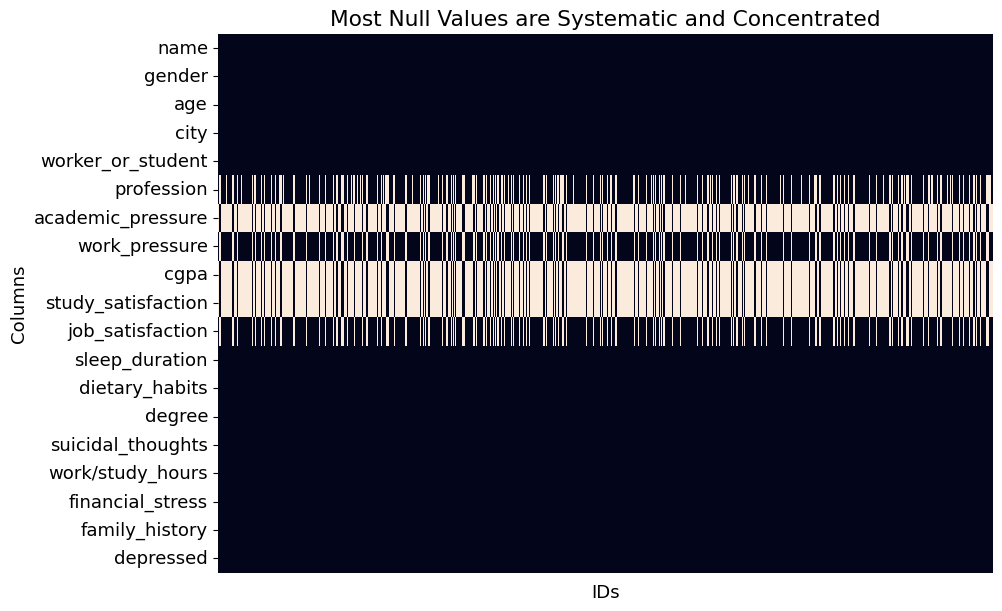

In [10]:
plt.figure(figsize=(10,7))
plt.title("Most Null Values are Systematic and Concentrated")
sns.heatmap(df_train.isna().T, vmin=0, vmax=1,cbar=False)
plt.xlabel("IDs")
plt.ylabel("Columns")
plt.xticks(ticks=[])
plt.show()

In [11]:
df_train.isna().sum().T

name                       0
gender                     0
age                        0
city                       0
worker_or_student          0
profession             36630
academic_pressure     112803
work_pressure          27918
cgpa                  112802
study_satisfaction    112803
job_satisfaction       27910
sleep_duration             0
dietary_habits             4
degree                     2
suicidal_thoughts          0
work/study_hours           0
financial_stress           4
family_history             0
depressed                  0
dtype: int64

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

imputer = SimpleImputer(strategy = "most_frequent")
df_train.loc[:,["dietary_habits", "degree", "financial_stress"]] = imputer.fit_transform(df_train[["dietary_habits", "degree", "financial_stress"]])
df_test.loc[:,["dietary_habits", "degree", "financial_stress"]] = imputer.transform(df_test[["dietary_habits", "degree", "financial_stress"]])

*Comments*

Now that we have imputed the minor random cases we can focus on the systematic missing values which likely relate to the student worker divide.

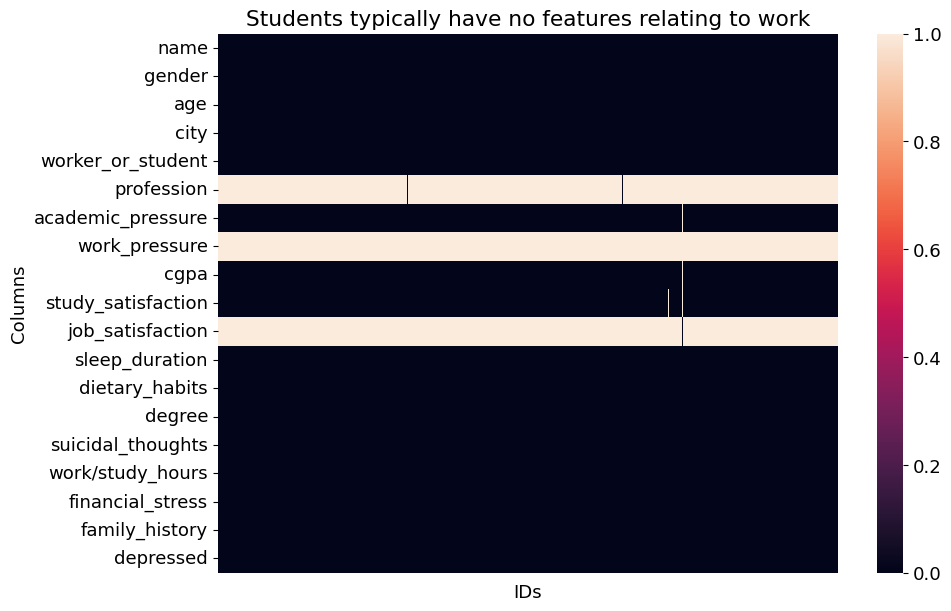

In [13]:
plt.figure(figsize=(10,7))
plt.title("Students typically have no features relating to work")
sns.heatmap(df_train[df_train["worker_or_student"]=="Student"].isna().T)
plt.xlabel("IDs")
plt.ylabel("Columns")
plt.xticks(ticks=[])
plt.show()

In [14]:
df_train[df_train["worker_or_student"]=="Student"].isna().sum()

name                      0
gender                    0
age                       0
city                      0
worker_or_student         0
profession            27867
academic_pressure         9
work_pressure         27898
cgpa                      9
study_satisfaction       10
job_satisfaction      27893
sleep_duration            0
dietary_habits            0
degree                    0
suicidal_thoughts         0
work/study_hours          0
financial_stress          0
family_history            0
depressed                 0
dtype: int64

In [15]:
imputer = SimpleImputer(strategy="most_frequent")
df_train.loc[df_train["worker_or_student"]=="Student",["academic_pressure", "cgpa", "study_satisfaction"]] = imputer.fit_transform(df_train.loc[df_train["worker_or_student"]=="Student",["academic_pressure", "cgpa", "study_satisfaction"]])
df_test.loc[df_test["worker_or_student"]=="Student",["academic_pressure", "cgpa", "study_satisfaction"]] = imputer.transform(df_test.loc[df_test["worker_or_student"]=="Student",["academic_pressure", "cgpa", "study_satisfaction"]])

c:\Users\JHMye\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


*Comments*

Now, let's check out our working professional case.

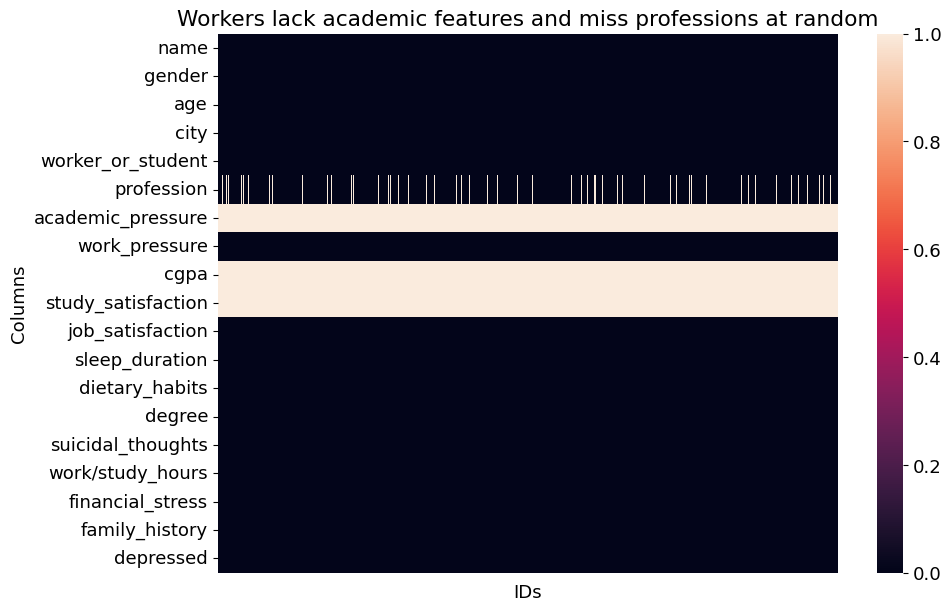

In [16]:
plt.figure(figsize=(10,7))
plt.title("Workers lack academic features and miss professions at random")
sns.heatmap(df_train[df_train["worker_or_student"]=="Working Professional"].isna().T)
plt.xlabel("IDs")
plt.ylabel("Columns")
plt.xticks(ticks=[])
plt.show()

In [17]:
df[df["worker_or_student"]=="Working Professional"].isna().sum()

name                      0
gender                    0
age                       0
city                      0
worker_or_student         0
profession             5886
academic_pressure     75026
work_pressure            10
cgpa                  75025
study_satisfaction    75025
job_satisfaction          9
sleep_duration            0
dietary_habits            0
degree                    0
suicidal_thoughts         0
work/study_hours          0
financial_stress          0
family_history            0
dtype: int64

In [18]:
imputer = SimpleImputer(strategy="most_frequent")
df_train.loc[df_train["worker_or_student"]=="Working Professional",["job_satisfaction","work_pressure"]] = imputer.fit_transform(df_train.loc[df_train["worker_or_student"]=="Working Professional",["job_satisfaction","work_pressure"]])
df_test.loc[df_test["worker_or_student"]=="Working Professional",["job_satisfaction","work_pressure"]] = imputer.transform(df_test.loc[df_test["worker_or_student"]=="Working Professional",["job_satisfaction","work_pressure"]])

c:\Users\JHMye\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


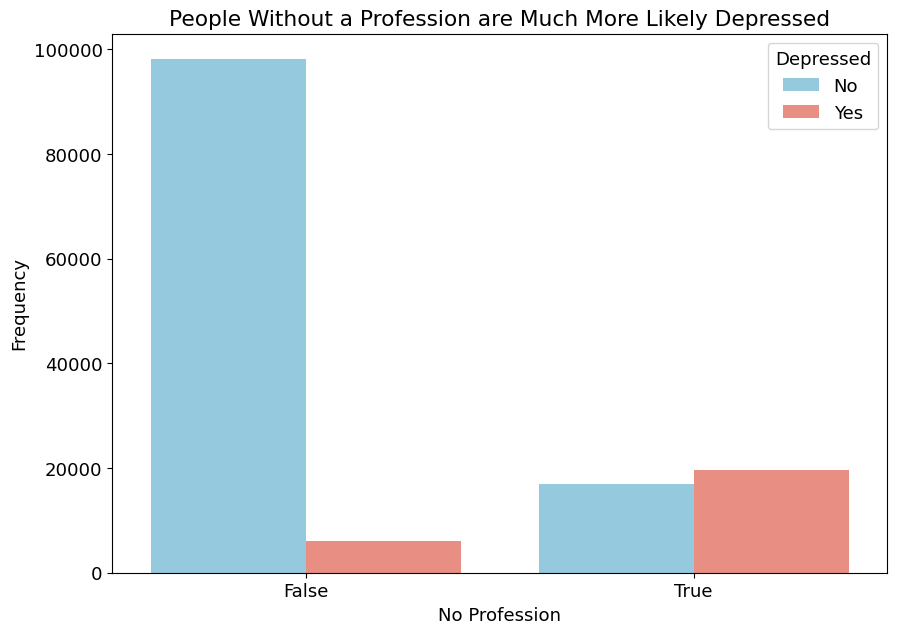

In [19]:
plt.figure(figsize=(10,7))
plt.title("People Without a Profession are Much More Likely Depressed")
sns.countplot(x=df_train["profession"].isna(), hue=df_train["depressed"], palette=["skyblue", "salmon"])
plt.xlabel("No Profession")
plt.ylabel("Frequency")
plt.legend(title="Depressed", labels=["No", "Yes"])
plt.show()

In [20]:
import scipy.stats as stats
import numpy as np

# Define observed frequencies based on given data
# Group A: Na_Profession = False
count_a = 104036
proportion_a = 0.057134
success_a = int(count_a * proportion_a)
failure_a = count_a - success_a

# Group B: Na_Profession = True
count_b = 8763
proportion_b = 0.375100
success_b = int(count_b * proportion_b)
failure_b = count_b - success_b

# Create a 2x2 contingency table
observed = np.array([[success_a, failure_a], [success_b, failure_b]])

# Perform the chi-squared test
chi2, p_value, _, _ = stats.chi2_contingency(observed)

p_value

0.0

*Comments*

We can see that there is large difference in prevelance of depression in our two cohorts, in the case of a working professional lending weight to the hypothesis that this is down to them being unemployed rather than an entry error.

In [21]:
#impute null values with unemployed
for df in datasets:
    df.loc[(df["worker_or_student"]=="Working Professional") & (df["profession"].isna()),"profession"] = "Unemployed"

In [22]:
df.isna().sum()

name                      0
gender                    0
age                       0
city                      0
worker_or_student         0
profession            18746
academic_pressure     75026
work_pressure         18768
cgpa                  75025
study_satisfaction    75025
job_satisfaction      18765
sleep_duration            0
dietary_habits            0
degree                    0
suicidal_thoughts         0
work/study_hours          0
financial_stress          0
family_history            0
dtype: int64

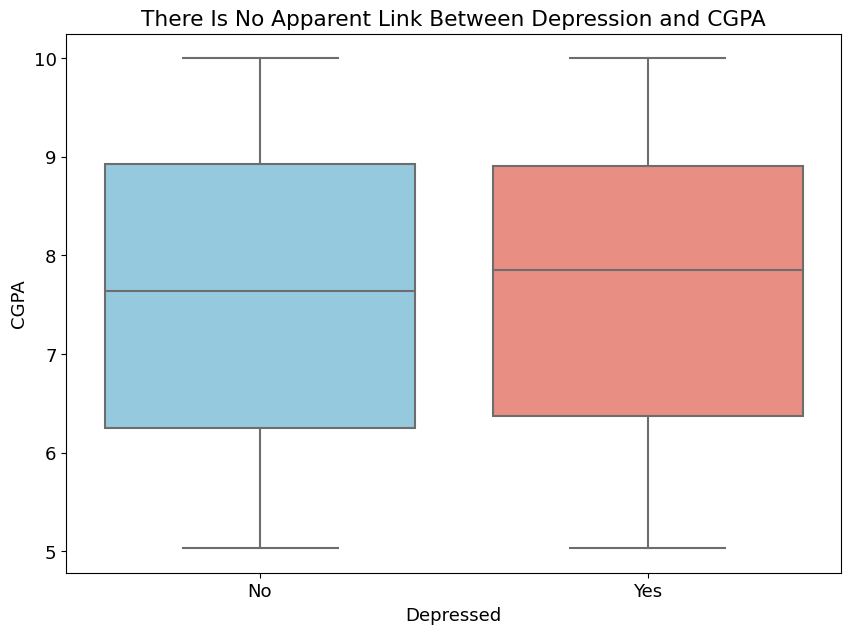

In [23]:
#We can drop CGPA becuase it complicates the workflow and does not inform on Depression


plt.figure(figsize=(10,7))
plt.title("There Is No Apparent Link Between Depression and CGPA")
sns.boxplot(data=df_train, y="cgpa", x="depressed",palette=["skyblue","salmon"])
plt.xlabel("Depressed")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.ylabel("CGPA")
plt.show()

In [24]:
for df in datasets:
    df.drop(columns="cgpa", inplace=True)

*Comments*

We can merge the pressure and satisfaction columns since they are complementary.

In [25]:
df_train["pressure"]=df_train["academic_pressure"].combine_first(df_train["work_pressure"])
df_test["pressure"]=df_test["academic_pressure"].combine_first(df_test["work_pressure"])

In [26]:
df_train["satisfaction"]=df_train["study_satisfaction"].combine_first(df_train["job_satisfaction"])
df_test["satisfaction"]=df_test["study_satisfaction"].combine_first(df_test["job_satisfaction"])

In [27]:
for df in datasets:
    df.drop(columns=["work_pressure", "academic_pressure","study_satisfaction", "job_satisfaction"], inplace=True)
    df["profession"] = df["profession"].combine_first(df["worker_or_student"])

In [28]:
df_train

,name,gender,age,city,worker_or_student,profession,sleep_duration,dietary_habits,degree,suicidal_thoughts,work/study_hours,financial_stress,family_history,depressed,pressure,satisfaction
id,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0,5.0,2.0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1,4.0,3.0
2,Yuvraj,Male,33.0,Visakhapatnam,Student,Student,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1,5.0,2.0
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1,5.0,1.0
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,Vidya,Female,18.0,Ahmedabad,Working Professional,Unemployed,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1,5.0,4.0
140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0,5.0,4.0
140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0,3.0,1.0


# Handle Erroneous Values

In this section we handle

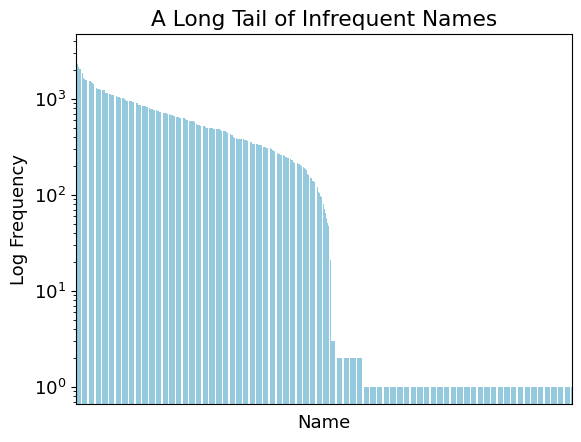

In [29]:
#Count the occurrences and sort by frequency
ordered_counts = df_train["name"].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values, color="skyblue")

#Add labels and title
plt.xlabel("Name")
plt.ylabel('Log Frequency')
plt.title('A Long Tail of Infrequent Names')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

*Comments*

We can see that in this log scale the Name variable has a long tail of single instances indicative of entry errors.

*Comment*

Given the low count in the tail we can cut it off and drop these contaminated rows.

In [30]:
# Precompute the index of values < 10
rare_names = ordered_counts[ordered_counts.values < 10].index

# Now use the precomputed result in the isin()
df_train.loc[df_train["name"].isin(rare_names),"name"] = "Other"

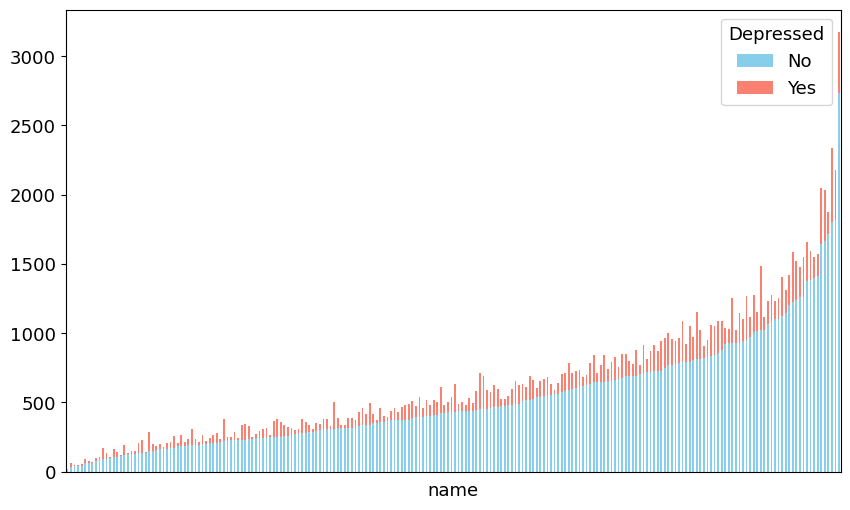

In [31]:
df_counts = df_train.groupby(['name', 'depressed']).size().unstack(fill_value=0).sort_values(by=0)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xticks([])
plt.legend(title= "Depressed", labels=["No", "Yes"])
plt.show()

In [32]:
for df in datasets:
    df.drop(columns = "name")

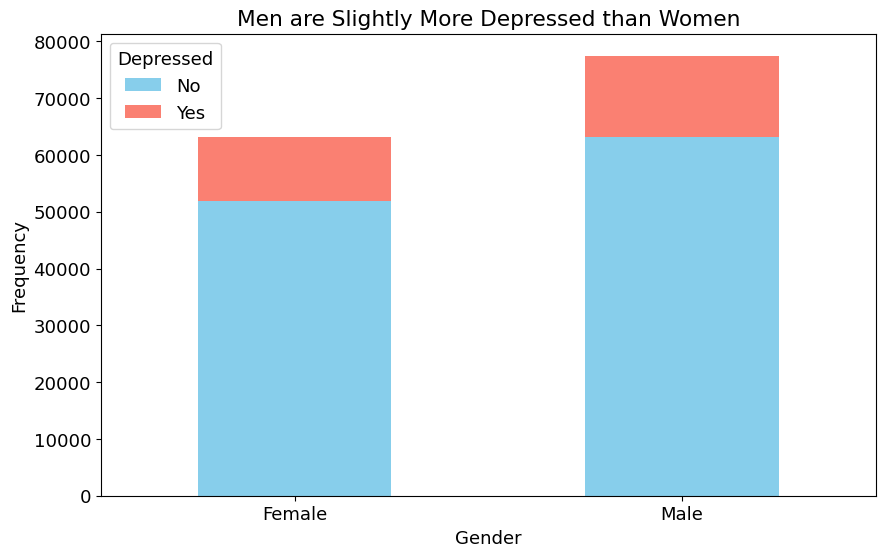

In [33]:
df_counts = df_train.groupby(['gender', 'depressed']).size().unstack(fill_value=0)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title("Men are Slightly More Depressed than Women")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.legend(title="Depressed", labels=["No", "Yes"])
plt.show()

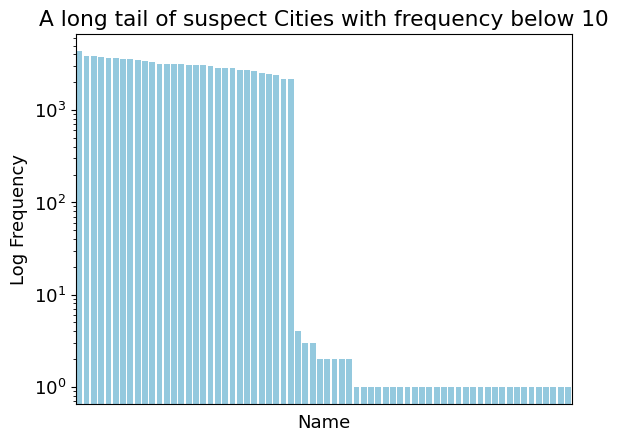

In [34]:
#Count the occurrences and sort by frequency
ordered_counts = df['city'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values, color="skyblue")

#Add labels and title
plt.xlabel('Name')
plt.ylabel('Log Frequency')
plt.title('A long tail of suspect Cities with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

*Comment*

Again we see a contaminated tail which can be dropped on grounds of it being low in count.

In [35]:
for df in datasets:
    city_frequencies = df["city"].value_counts()
    df.loc[df["city"].isin(city_frequencies[city_frequencies < 10].index),"city"] = "Other"

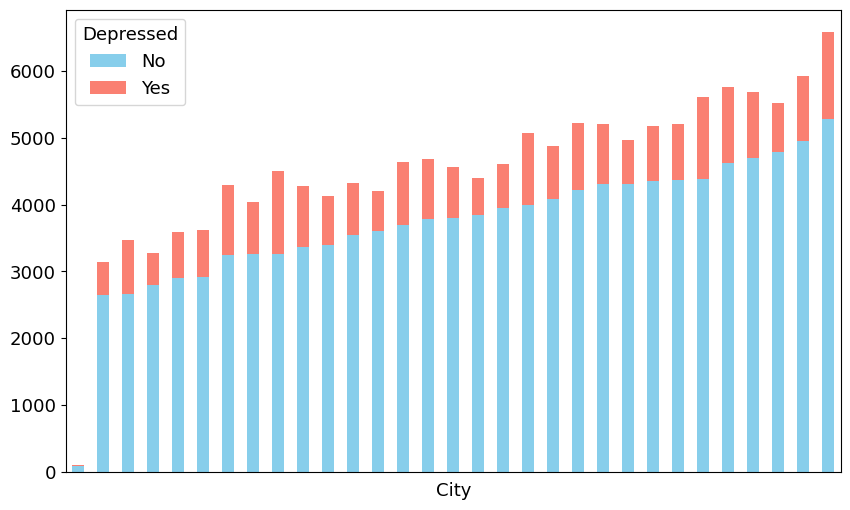

In [36]:
df_counts = df_train.groupby(['city', 'depressed']).size().unstack(fill_value=0).sort_values(by=0)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xticks([])
plt.legend(title= "Depressed", labels=["No", "Yes"])
plt.xlabel("City")
plt.show()

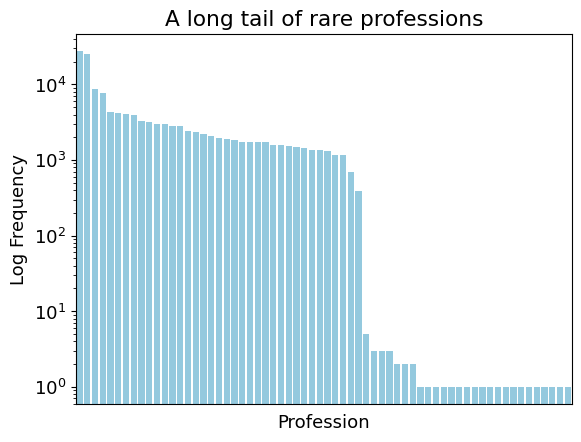

In [37]:
#Count the occurrences and sort by frequency
ordered_counts = df_train['profession'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values, color="skyblue")

#Add labels and title
plt.xlabel('Profession')
plt.ylabel('Log Frequency')
plt.title('A long tail of rare professions')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [38]:
for df in datasets:
    profession_frequencies = df["profession"].value_counts()
    df.loc[df["profession"].isin(profession_frequencies[profession_frequencies < 10].index),"profession"] = "Other"

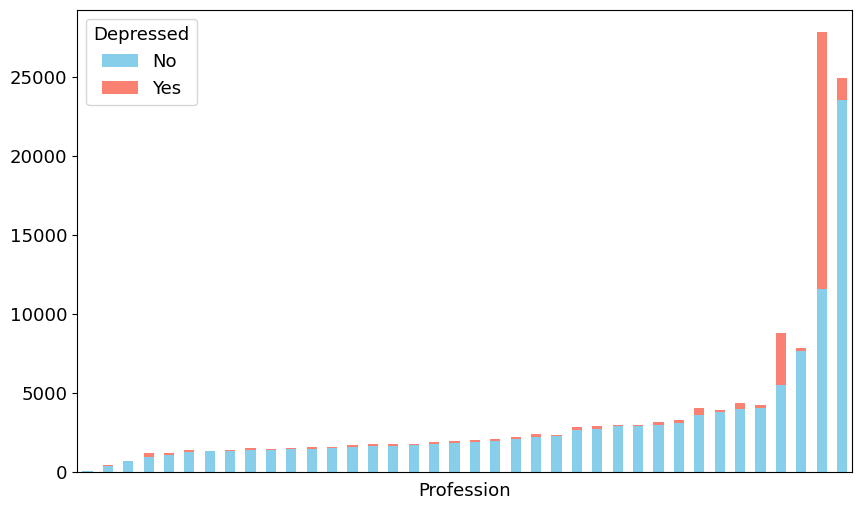

In [39]:
df_counts = df_train.groupby(['profession', 'depressed']).size().unstack(fill_value=0).sort_values(by=0)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xticks([])
plt.legend(title= "Depressed", labels=["No", "Yes"])
plt.xlabel("Profession")
plt.show()

In [40]:
df_train["student"]=df_train["profession"].apply(lambda x: 1 if x=="Student" else 0)
df_train["unemployed"]=df_train["profession"].apply(lambda x: 1 if x=="Unemployed" else 0)

In [41]:
df_test["student"]=df_test["profession"].apply(lambda x: 1 if x=="Student" else 0)
df_test["unemployed"]=df_test["profession"].apply(lambda x: 1 if x=="Unemployed" else 0)

*Comments*

We can see two clear outliers here unemployed and student.

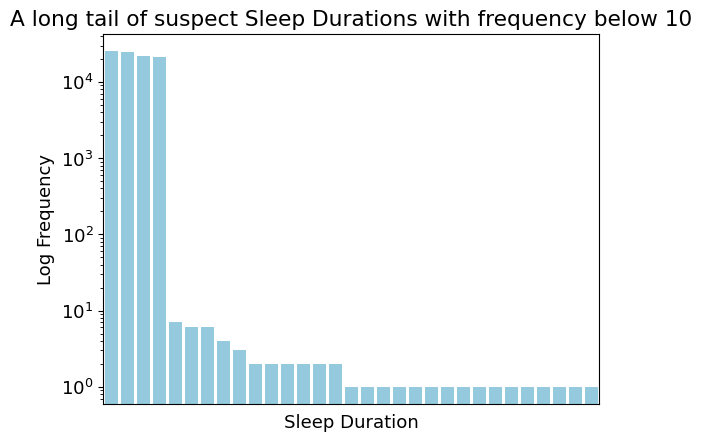

In [42]:
#Count the occurrences and sort by frequency
ordered_counts = df['sleep_duration'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values,color="skyblue")

#Add labels and title
plt.xlabel('Sleep Duration')
plt.ylabel('Log Frequency')
plt.title('A long tail of suspect Sleep Durations with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [43]:
for df in datasets:
    sleep_frequencies = df["sleep_duration"].value_counts()
    df.loc[df["sleep_duration"].isin(sleep_frequencies[sleep_frequencies <= 50].index),"sleep_duration"] = "Other"

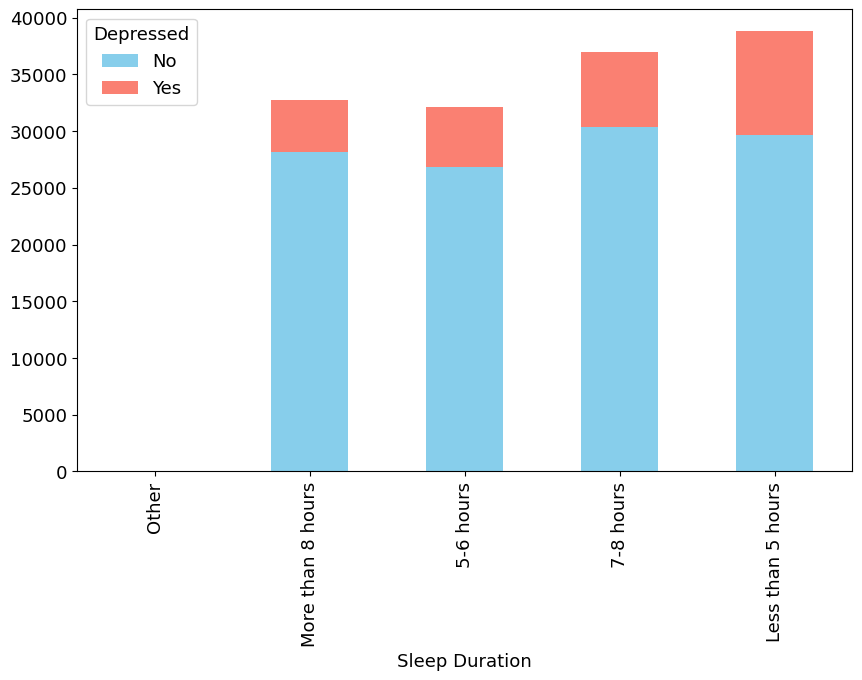

In [44]:
df_counts = df_train.groupby(['sleep_duration', 'depressed']).size().unstack(fill_value=0).sort_values(by=1)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.legend(title= "Depressed", labels=["No", "Yes"])
plt.xlabel("Sleep Duration")
plt.show()

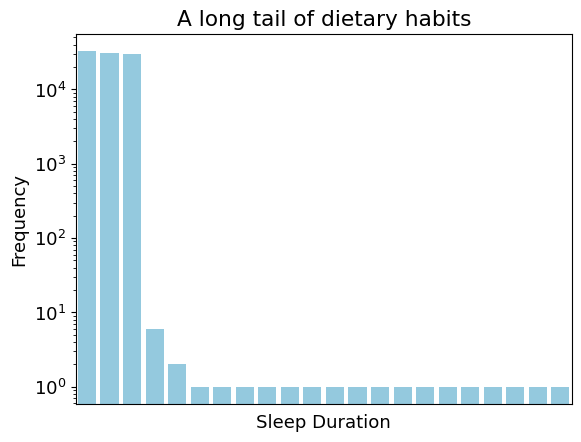

In [45]:
#Count the occurrences and sort by frequency
ordered_counts = df_test['dietary_habits'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values,color="skyblue")

#Add labels and title
plt.xlabel('Sleep Duration')
plt.ylabel('Frequency')
plt.title('A long tail of dietary habits')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [46]:
for df in datasets:
    diet_frequencies = df["dietary_habits"].value_counts()
    df.loc[df["dietary_habits"].isin(diet_frequencies[diet_frequencies < 10].index),"dietary_habits"] = "Other"

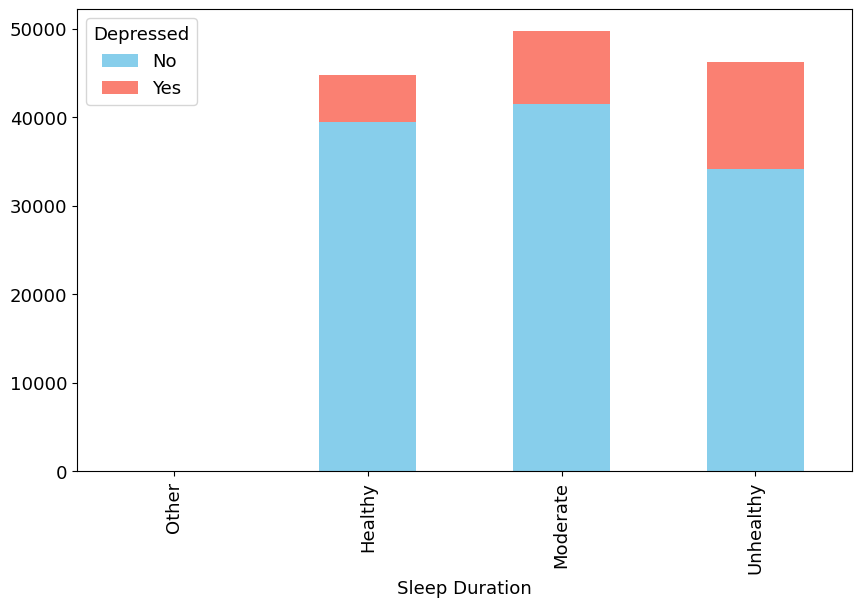

In [47]:
df_counts = df_train.groupby(["dietary_habits", 'depressed']).size().unstack(fill_value=0).sort_values(by=1)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.legend(title= "Depressed", labels=["No", "Yes"])
plt.xlabel("Sleep Duration")
plt.show()

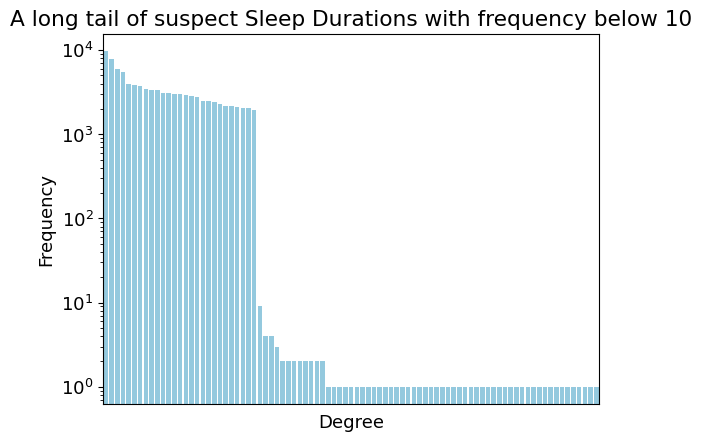

In [48]:
#Count the occurrences and sort by frequency
ordered_counts = df['degree'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values,color="skyblue")

#Add labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('A long tail of suspect Sleep Durations with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [49]:
for df in datasets:
    degree_frequencies = df["degree"].value_counts()
    df.loc[df["degree"].isin(degree_frequencies[degree_frequencies < 10].index),"degree"] = "Other"

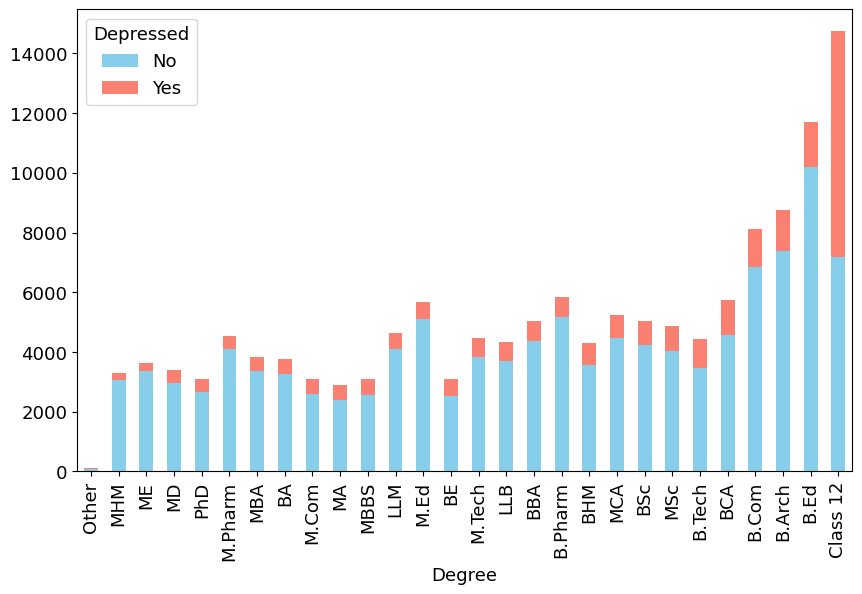

In [50]:
df_counts = df_train.groupby(["degree", 'depressed']).size().unstack(fill_value=0).sort_values(by=1)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.legend(title= "Depressed", labels=["No", "Yes"])
plt.xlabel("Degree")
plt.show()

In [51]:
df_train["class_12"]=df_train["degree"].apply(lambda x: 1 if x=="Class 12" else 0)
df_test["class_12"]=df_test["degree"].apply(lambda x: 1 if x=="Class 12" else 0)

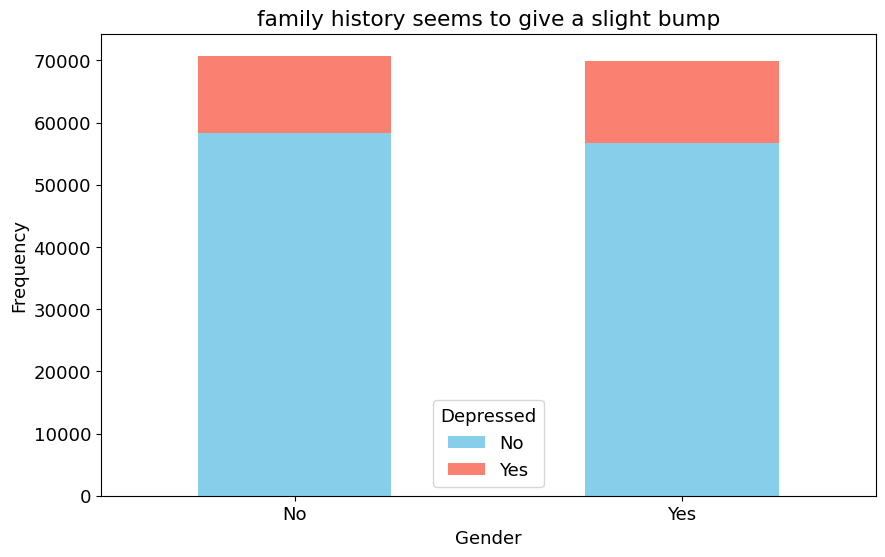

In [52]:
df_counts = df_train.groupby(['family_history', 'depressed']).size().unstack(fill_value=0)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title("family history seems to give a slight bump")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.legend(title="Depressed", labels=["No", "Yes"])
plt.show()

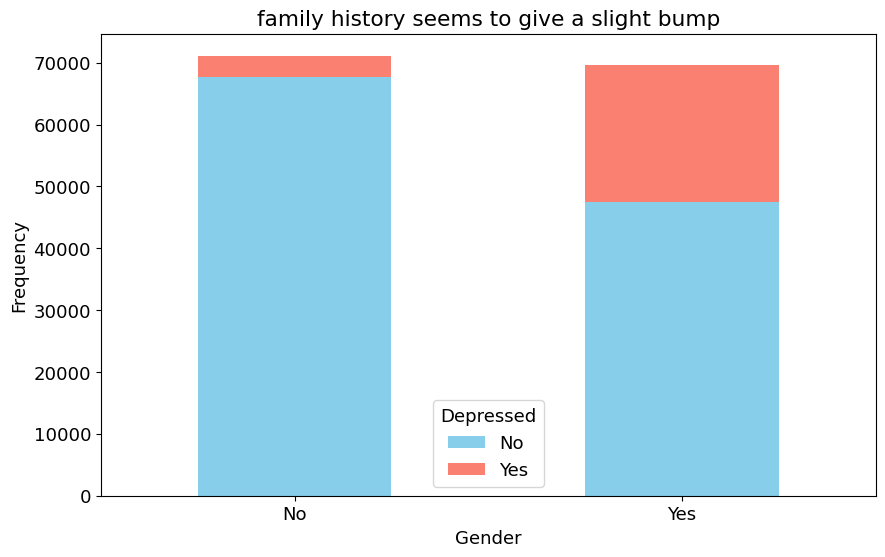

In [53]:
df_counts = df_train.groupby(['suicidal_thoughts', 'depressed']).size().unstack(fill_value=0)
df_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title("family history seems to give a slight bump")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.legend(title="Depressed", labels=["No", "Yes"])
plt.show()

Now we can examine the numerical values

# Handle Duplicate Values

In [54]:
#We can see there are no duplicated values.
df_train.duplicated().sum()

0

# Univariate Analysis

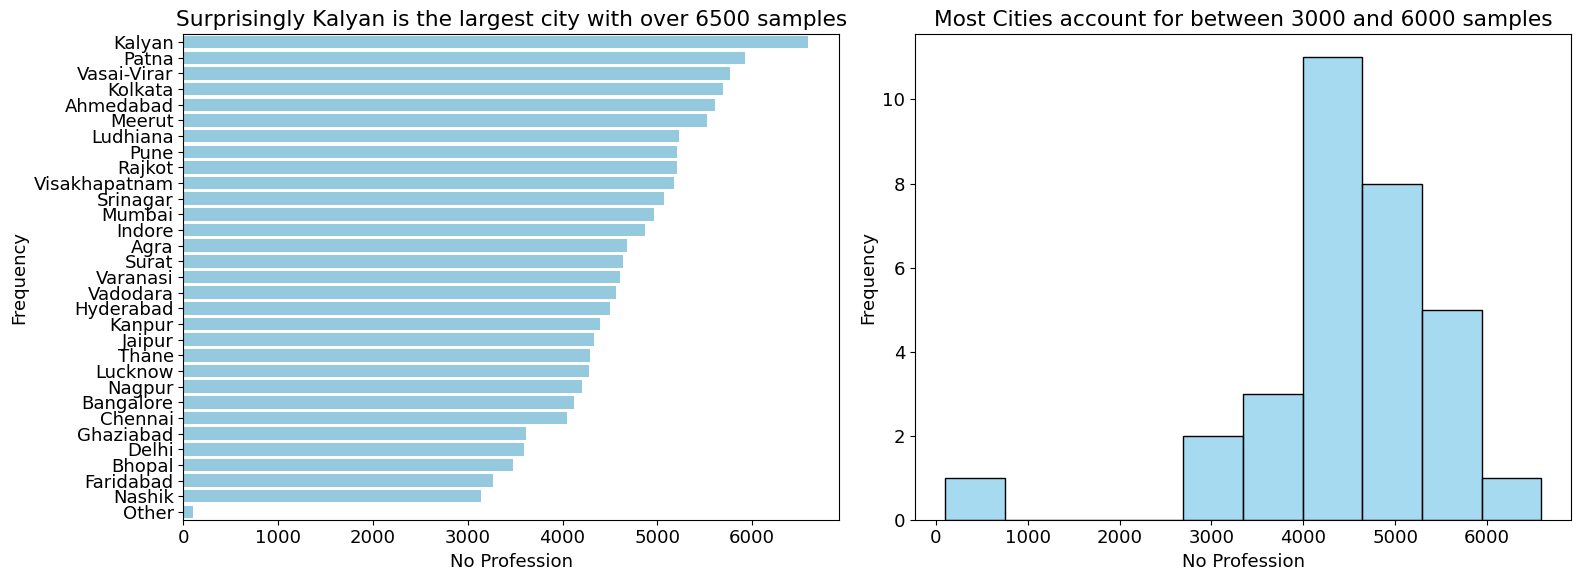

In [142]:
# Assuming df_train["city"] contains categorical data to analyze
df = df_train["city"].value_counts().sort_values(ascending=False)

# Create a figure with 1 row and 2 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figsize as needed

# First subplot: Barplot
axes[0].set_title("Surprisingly Kalyan is the largest city with over 6500 samples")
sns.barplot(y=df.index, x=df.values, palette=["skyblue"], ax=axes[0])
axes[0].set_xlabel("No Profession")
axes[0].set_ylabel("Frequency")

# Second subplot: Histogram
axes[1].set_title("Most Cities account for between 3000 and 6000 samples")
sns.histplot(x=df.values, color="skyblue", ax=axes[1])
axes[1].set_xlabel("No Profession")
axes[1].set_ylabel("Frequency")

# Adjust layout for clarity
plt.tight_layout()
plt.show()

In [127]:
styled_table = df.to_frame().describe().T.style.set_caption("Summary Statistics").set_table_styles(
    [
        {"selector": "caption", "props": [("text-align", "center"), ("font-size", "16px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("background-color", "#f4f4f4"), ("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "right")]}
    ]
)
styled_table

,count,mean,std,min,25%,50%,75%,max
city,31.000000,4538.709677,1159.796568,98.000000,4166.000000,4606.000000,5208.500000,6591.000000


*Comments* 

Given that most cities in your dataset have sample sizes ranging between 3,000 and 6,000, with an average sample size of 4,500 across 31 cities, the situation becomes noteworthy when considering that Kalyan, with a population of less than 2 million, has the highest sample size, while Mumbai, which has a population of over 25 million, has only half that number of samples. This disparity raises concerns about potential sample bias or suggests that a specific stratification or targeted sampling approach may have been employed.

In such cases, it’s important to critically evaluate whether the overrepresentation of Kalyan might reflect a deliberate choice based on certain demographic or socio-economic factors, or if it may unintentionally skew the results, particularly if the aim was to sample proportionally based on population size. Such an imbalance warrants further investigation to ensure that the sampling strategy is fair and aligns with the study's objectives, avoiding any unintentional bias.

c:\Users\JHMye\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


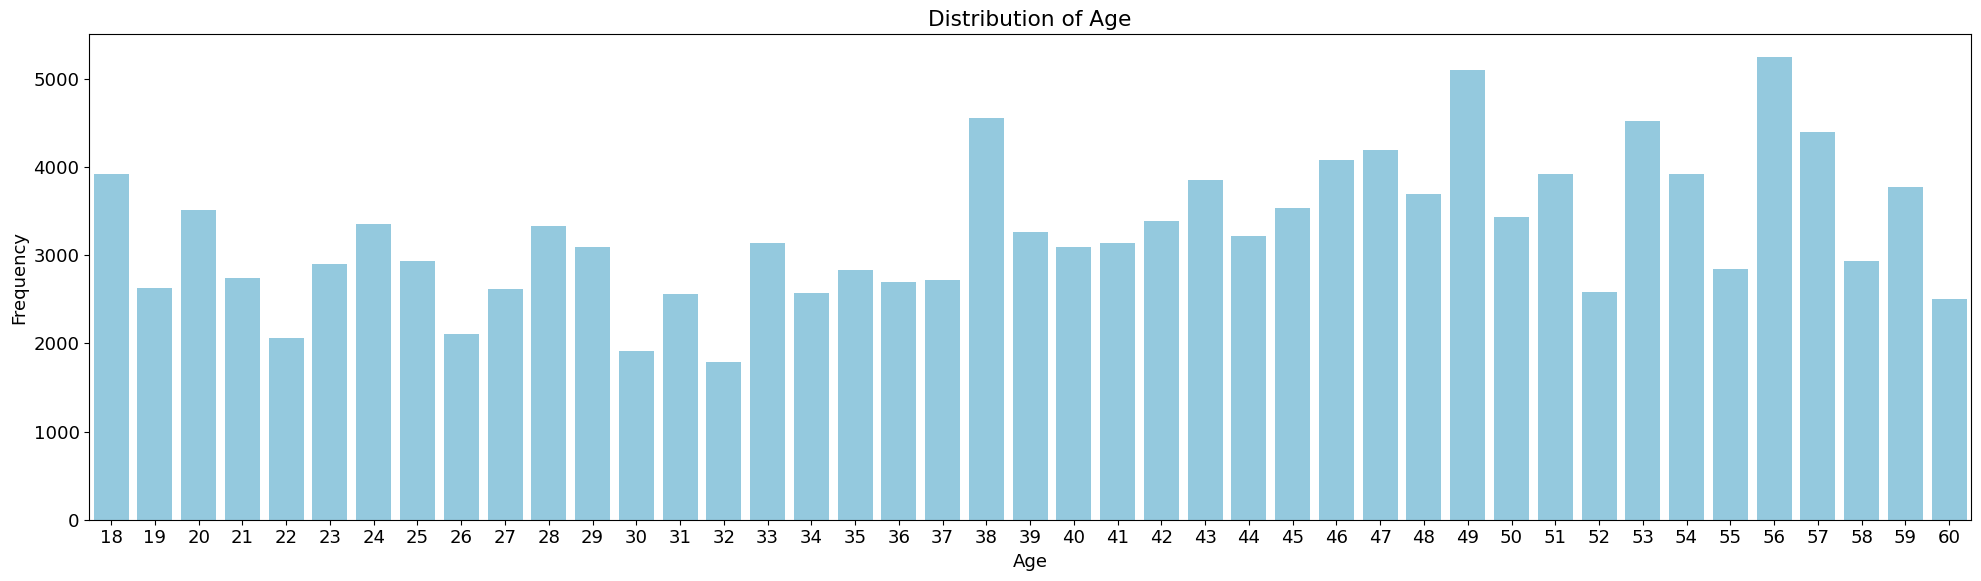

In [ ]:
# Assuming df_train["age"] contains the data you want to plot
df = df_train["age"].astype("int")

# Create a figure for the histogram
plt.figure(figsize=(20, 6))  # Adjust figsize as needed

# Plot histogram
sns.countplot(df, color="skyblue")

# Set title and labels
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
#plt.xticks(ticks=np.arange(0,61,1))

# Show plot
plt.tight_layout()
plt.show()

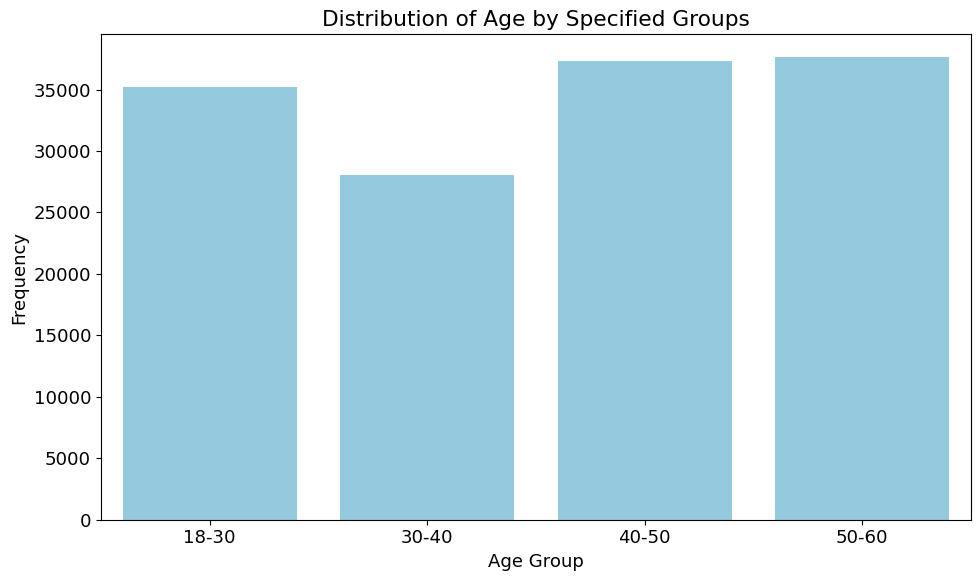

In [ ]:
# Assuming df_train["age"] contains the data you want to plot
df = df_train["age"].astype("int")

# Define the bins and labels
bins = [18, 30, 40, 50, 60]
labels = ['18-30', '30-40', '40-50', '50-60']

# Bin the ages into the specified groups
df_binned = pd.cut(df, bins=bins, labels=labels, right=False)  # right=False includes the left edge, but excludes the right edge

# Create a figure for the count plot
plt.figure(figsize=(10, 6))  # Adjust figsize as needed

# Plot countplot for the binned data
sns.countplot(x=df_binned, color="skyblue")

# Set title and labels
plt.title("Distribution of Age by Specified Groups")
plt.xlabel("Age Group")
plt.ylabel("Frequency")

# Show plot
plt.tight_layout()
plt.show()

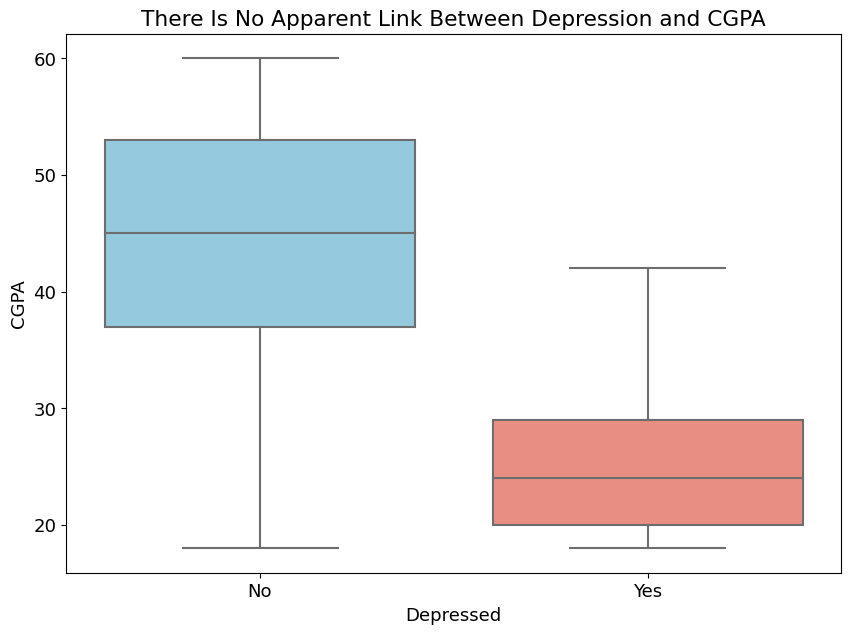

In [ ]:
plt.figure(figsize=(10,7))
plt.title("We can see a ")
sns.boxplot(data=df_train, y="age", x="depressed",palette=["skyblue","salmon"],showfliers=False)
plt.xlabel("Depressed")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.ylabel("CGPA")
plt.show()

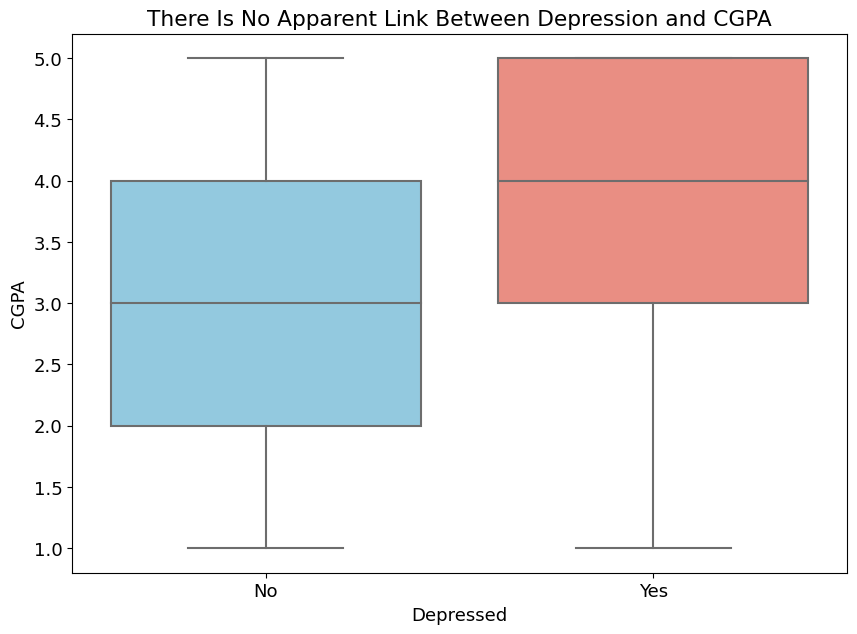

In [ ]:
plt.figure(figsize=(10,7))
plt.title("There Is No Apparent Link Between Depression and CGPA")
sns.boxplot(data=df_train, y="financial_stress", x="depressed",palette=["skyblue","salmon"],showfliers=False)
plt.xlabel("Depressed")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.ylabel("CGPA")
plt.show()

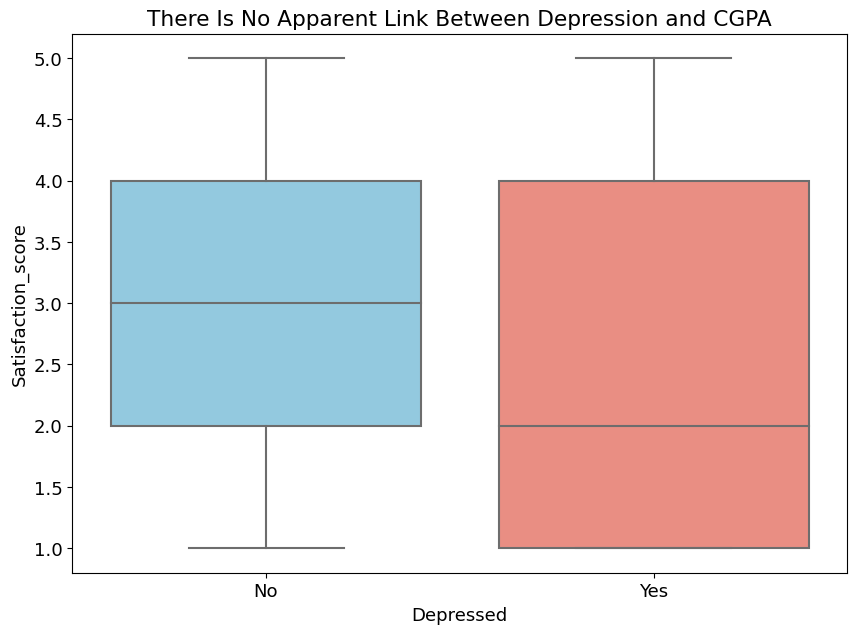

In [ ]:
plt.figure(figsize=(10,7))
plt.title("There Is No Apparent Link Between Depression and CGPA")
sns.boxplot(data=df_train, y="satisfaction", x="depressed",palette=["skyblue","salmon"],showfliers=False)
plt.xlabel("Depressed")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.ylabel("Satisfaction_score")
plt.show()

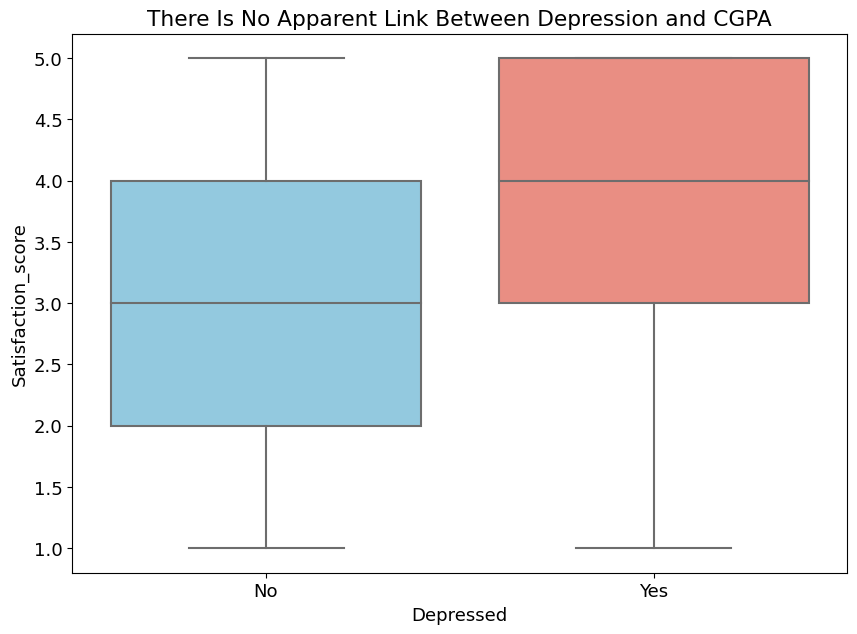

In [ ]:
plt.figure(figsize=(10,7))
plt.title("There Is No Apparent Link Between Depression and CGPA")
sns.boxplot(data=df_train, y="pressure", x="depressed",palette=["skyblue","salmon"],showfliers=False)
plt.xlabel("Depressed")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.ylabel("Satisfaction_score")
plt.show()

*Comments*

Clearly only adults from 18 to 60 have been asked, looks roughly uniform.

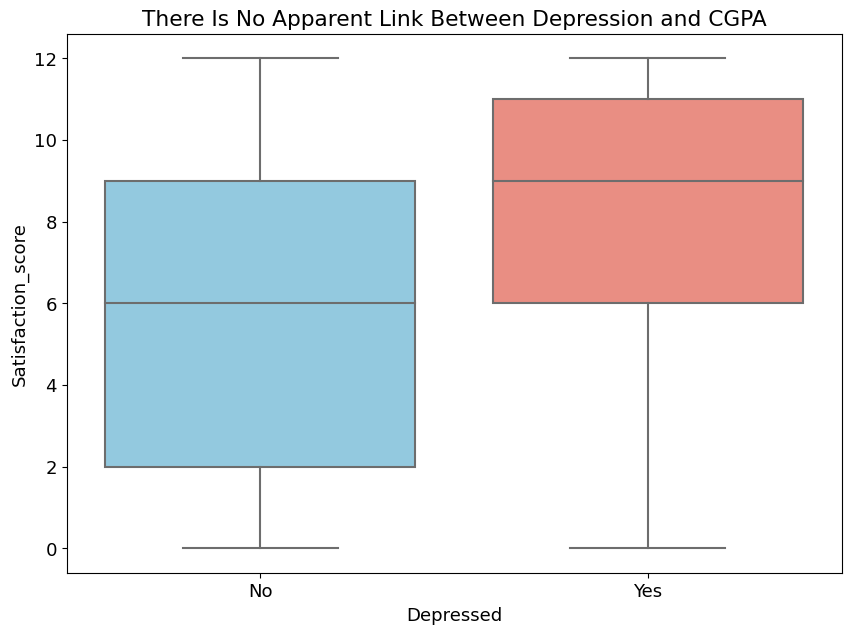

In [ ]:
plt.figure(figsize=(10,7))
plt.title("There Is No Apparent Link Between Depression and CGPA")
sns.boxplot(data=df_train, y="work/study_hours", x="depressed",palette=["skyblue","salmon"],showfliers=False)
plt.xlabel("Depressed")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.ylabel("Satisfaction_score")
plt.show()

C:\Users\user1\AppData\Local\Temp\ipykernel_904\2137687708.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr().round(1),cmap="coolwarm",annot=True)


<Axes: >

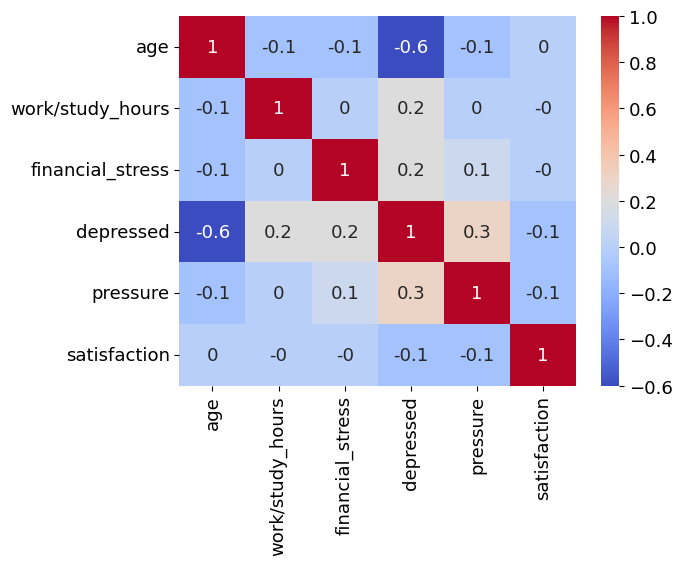

In [ ]:
sns.heatmap(df_train.corr().round(1),cmap="coolwarm",annot=True)


# Data Dictionary with Updated Variable Names

| Column Name                               | Data Type   | Variable Type    | Cardinality                      | Range                          | Description                                                                 |
|-------------------------------------------|-------------|------------------|----------------------------------|--------------------------------|-----------------------------------------------------------------------------|
| `name`                                    | object      | Nominal          | High (likely unique for each individual) | N/A                          | Name of the individual (categorical).                                       |
| `gender`                                  | object      | Nominal          | 2                                | "Male", "Female"                          | Gender of the individual (e.g., male, female, other).                       |
| `age`                                     | float64     | Continuous       | Moderate                        | 18-60                       | Age of the individual (numeric).                                            |
| `city`                                    | object      | Nominal          | High                             | "Mumbai", "Dehli" etc.                         | City of residence (categorical).                                            |
| `worker_or_student`                       | object      | Nominal          | 2                                | "Working Professional","Student"                          | Employment status: worker or student (categorical).                         |
| `profession`                              | object      | Nominal          | Moderate to High (depending on dataset) | "Baker","Unemployed" etc.                        | Profession of the individual (categorical, with missing values).            |
| `academic_pressure`                       | float64     | Discrete         | 5                                | 1–5                          | Level of academic pressure experienced (numeric, many missing values).      |
| `work_pressure`                           | float64     | Discrete         | 5                                | 1–5                          | Level of work pressure experienced (numeric, some missing values).          |
| `cgpa`                                    | float64     | Discrete         | 5                                | 1–5                          | Academic performance measured in CGPA (numeric, many missing values).       |
| `study_satisfaction`                      | float64     | Discrete         | 5                                | 1–5                          | Satisfaction level with academic studies (numeric, many missing values).    |
| `job_satisfaction`                        | float64     | Discrete         | 5                                | 1–5                          | Satisfaction level with current job (numeric, some missing values).         |
| `sleep_duration`                          | object      | Ordinal          | Low                              | N/A                          | Sleep duration, typically in hours (categorical).                           |
| `dietary_habits`                          | object      | Ordinal          | Low                              | N/A                          | Dietary habits (e.g., vegetarian, non-vegetarian, vegan) (categorical).     |
| `degree`                                  | object      | Nominal          | Moderate                        | N/A                          | Highest degree attained (categorical).                                      |
| `suicidal_thoughts`                       | object      | Binary           | 2                                | Yes/No                       | History of suicidal thoughts (Yes/No).                                      |
| `work/study_hours`                        | float64     | Continuous       | Moderate                        | 0–24                         | Average work or study hours per day (numeric).                              |
| `financial_stress`                        | float64     | Discrete         | Moderate                        | 1–5                          | Level of financial stress experienced (numeric, some missing values).       |
| `family_history`                          | object      | Binary           | 2                                | Yes/No                       | Family history of mental illness (Yes/No).                                  |
| `depressed`                               | int64       | Binary           | 2                                | 0–1                          | Target variable: presence of depression (1 = Yes, 0 = No).                  |


# Feature Engineering

Let's perform target encoding on the nominal columns with high cardinality: Name, City, Profession, Degree

In [ ]:
from sklearn.preprocessing import TargetEncoder

encoder = TargetEncoder(target_type="binary", cv=5)

df_train[[f"{column}_encoded" for column in ["name", "city", "profession", "degree"]]] = encoder.fit_transform(df_train[["name", "city", "profession", "degree"]], df_train["depressed"])
df_test[[f"{column}_encoded" for column in ["name", "city", "profession", "degree"]]] = encoder.transform(df_test[["name", "city", "profession", "degree"]])

In [ ]:
plt.figure(figsize=(10,7))
plt.title("There Is No Apparent Link Between Depression and CGPA")
sns.boxplot(data=df_train, y="name_encoded", x="depressed",palette=["skyblue","salmon"],showfliers=False)
plt.xlabel("Depressed")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.ylabel("Satisfaction_score")
plt.show()

NameError: name 'plt' is not defined

<Axes: xlabel='depressed', ylabel='city_encoded'>

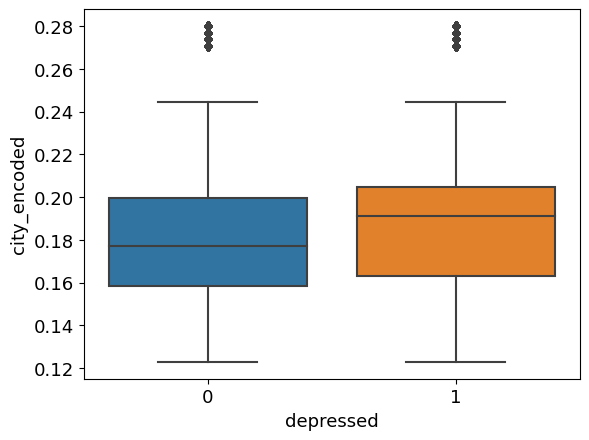

In [ ]:
sns.boxplot(y=df_train["city_encoded"],x=df_train["depressed"])

<Axes: xlabel='depressed', ylabel='degree_encoded'>

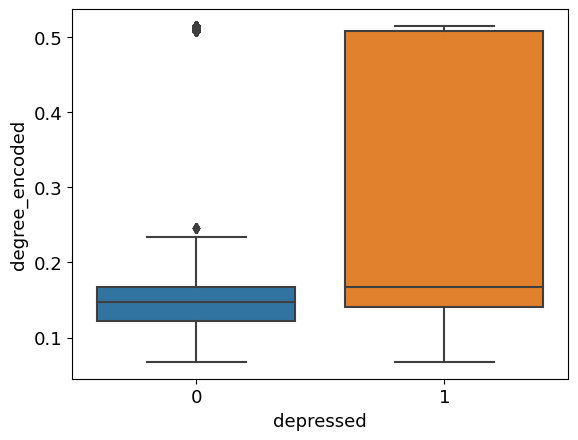

In [ ]:
sns.boxplot(y=df_train["degree_encoded"],x=df_train["depressed"])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop="if_binary")  # `sparse=False` gives a dense array


# Fit and transform the 'Category' column
encoded_columns = encoder.fit_transform(df_train[["gender","suicidal_thoughts", "family_history"]])

    # Convert the array to a DataFrame with meaningful column names
encoded_df = pd.DataFrame(
    encoded_columns, 
    columns=["gender_encoded", "suicidal_encoded", "history_encoded"]
)

    # Drop the original 'Category' column and concatenate the encoded columns
df_train = pd.concat([df_train, encoded_df], axis=1)

In [ ]:
#transform the 'Category' column
encoded_columns = encoder.transform(df_test[["gender","suicidal_thoughts", "family_history"]])

    # Convert the array to a DataFrame with meaningful column names
encoded_df = pd.DataFrame(
    encoded_columns, index=df_test.index,
    columns=["gender_encoded", "suicidal_encoded", "history_encoded"]
)

    # Drop the original 'Category' column and concatenate the encoded columns
df_test = pd.concat([df_test, encoded_df], axis=1)

# Ordinal Encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
encoder = OrdinalEncoder(min_frequency=100)

In [ ]:
data = encoder.fit_transform(df_train[["sleep_duration", "dietary_habits"]])

df_encoded = pd.DataFrame(data=data, columns=["sleep_encoded","diet_encoded"], index=df_train.index)

df_train = pd.concat([df_train, df_encoded], axis=1)

In [ ]:
data = encoder.transform(df_test[["sleep_duration", "dietary_habits"]])

df_encoded = pd.DataFrame(data=data, columns=["sleep_encoded","diet_encoded"], index=df_test.index)

df_test = pd.concat([df_test, df_encoded], axis=1)

<Axes: xlabel='depressed', ylabel='sleep_encoded'>

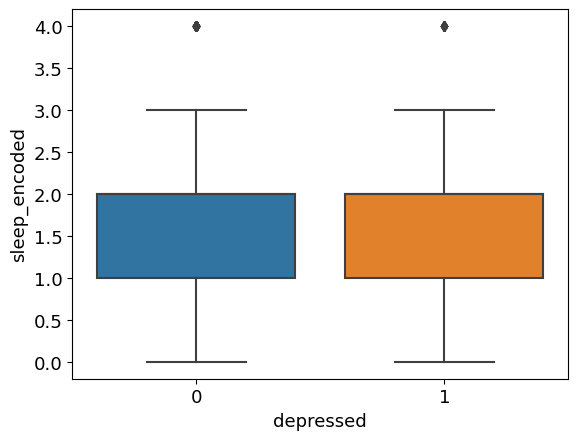

In [ ]:
sns.boxplot(y=df_train["sleep_encoded"],x=df_train["depressed"])

Depression,0,1
Sleep Duration,,
5-8 Hours,56969,11850
Less than 5 hours,29581,9057
More than 8 hours,28086,4524


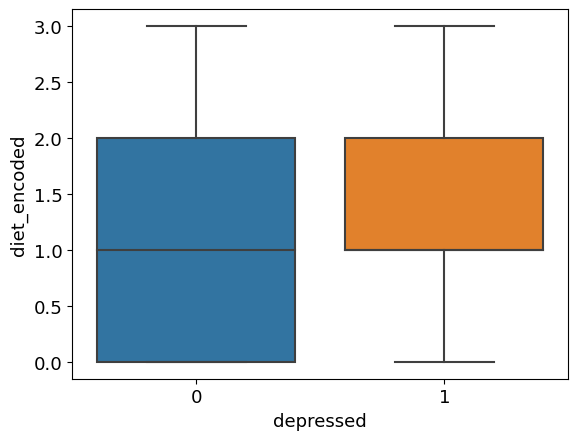

In [ ]:
sns.boxplot(y=df_train["diet_encoded"],x=df_train["depressed"])

C:\Users\user1\AppData\Local\Temp\ipykernel_13248\2800688033.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(df_train.corr(),1),annot=True)


<Axes: >

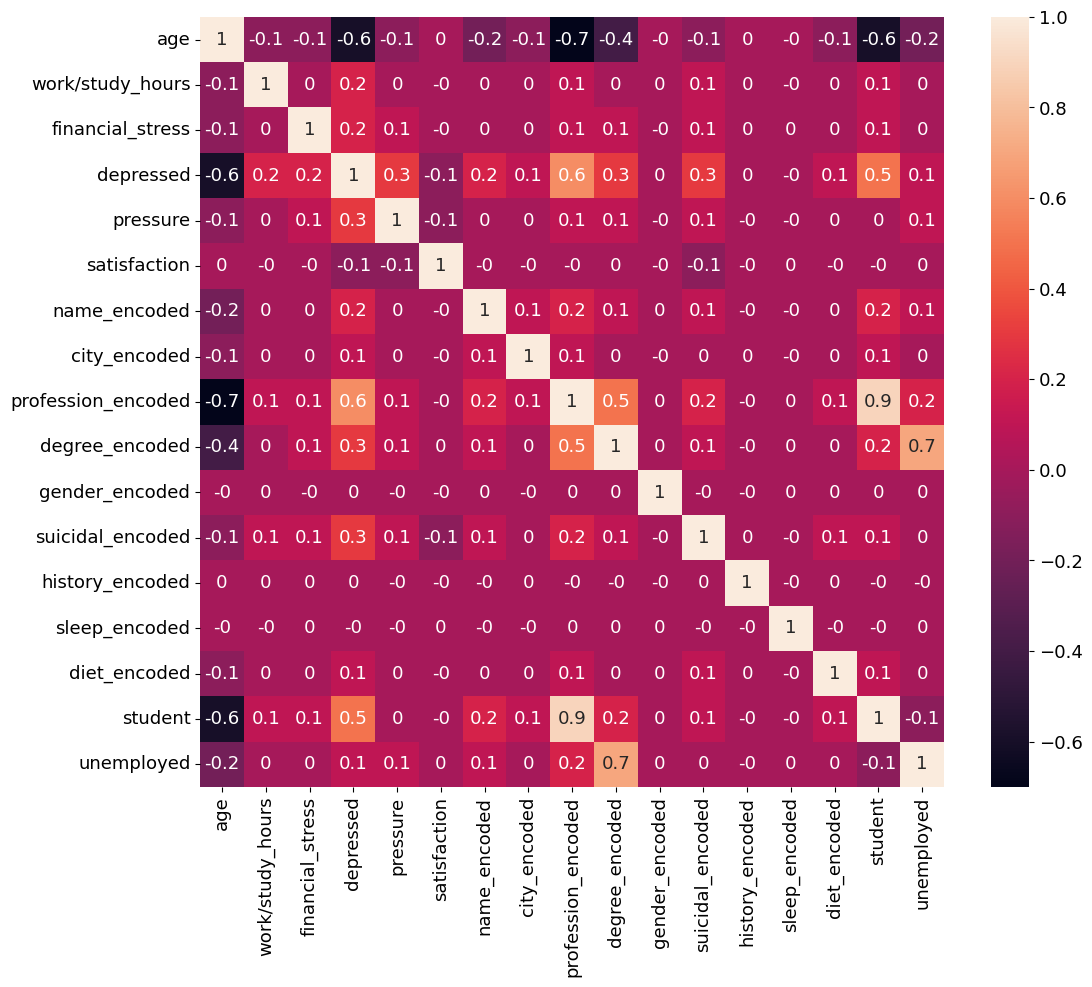

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(round(df_train.corr(),1),annot=True)

# Modelling

In [ ]:
X_train = df_train.select_dtypes(include=np.number).drop(columns=["depressed"])
X_test = df_test.select_dtypes(include=np.number)
y_train = df_train["depressed"]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define the F1 scorer
f1_scorer = make_scorer(f1_score)

# Full pipeline with scaler
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100,200],
    'classifier__max_depth': [None,10,20],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1,2]
}

# Perform grid search with F1 score optimization
grid_search = GridSearchCV(pipeline, param_grid, scoring=f1_scorer, cv=5, verbose=5)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.818 total time=  18.0s
[CV 2/5] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.821 total time=  19.1s
[CV 3/5] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.818 total time=  15.0s
[CV 4/5] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.820 total time=  15.2s
[CV 5/5] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.826 total time=  15.3s
[CV 1/5] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_s

KeyboardInterrupt: 

In [ ]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=None,  min_samples_leaf=2, min_samples_split=5)
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [ ]:
# Evaluate the model
report = classification_report(rfc.predict(X_train),y_train)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    115955
           1       0.94      0.97      0.95     24745

    accuracy                           0.98    140700
   macro avg       0.96      0.98      0.97    140700
weighted avg       0.98      0.98      0.98    140700



<Axes: >

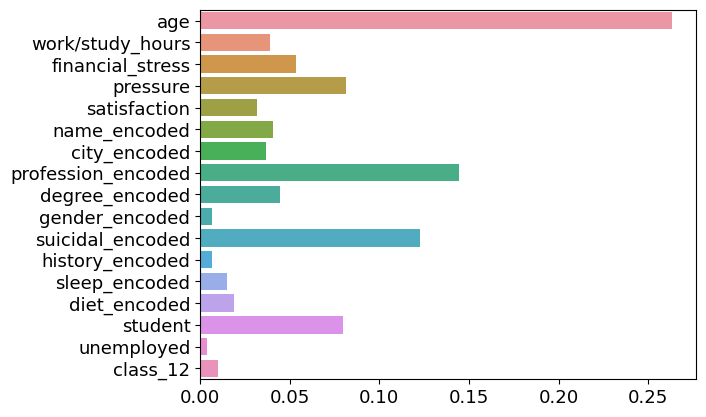

In [ ]:
sns.barplot(y=X_train.columns, x=rfc.feature_importances_,)

In [ ]:
submission_df = pd.DataFrame(data=np.array([X_test.index, rfc.predict(X_test)]).T, columns=["id", "Depression"]).set_index("id")
submission_df.to_csv("mh_submission.csv")

In [ ]:
submission_df

,Id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


- use a pipeline
- use cross-validation